In [1]:
!pip install smogn

In [2]:
!pip install git+https://github.com/nickkunz/smogn.git # official github

  Cloning https://github.com/nickkunz/smogn.git to /tmp/pip-req-build-icxj64xv
  Running command git clone --filter=blob:none --quiet https://github.com/nickkunz/smogn.git /tmp/pip-req-build-icxj64xv
  Resolved https://github.com/nickkunz/smogn.git to commit e4e5e4aca43a07ebbd1a0ed881f4de1e24abb8ed
  Preparing metadata (setup.py) ... done
  Created wheel for smogn: filename=smogn-0.1.1-py3-none-any.whl size=31239 sha256=a3c7a982662687d720cec9bc4556cce07e33f837615de97e1cdcbe61beb47a17
  Stored in directory: /tmp/pip-ephem-wheel-cache-6emfuzvc/wheels/76/86/27/151e970eff5b6305a42b0f7dfd8a266d5014a25e377a2903bf
Successfully built smogn
  Attempting uninstall: smogn
    Found existing installation: smogn 0.1.2
    Uninstalling smogn-0.1.2:
      Successfully uninstalled smogn-0.1.2


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, random,sys, json,zipfile, time
from copy import deepcopy
import plotly.graph_objects as go
import math
from scipy.stats import spearmanr
import plotly.express as px
from scipy.optimize import minimize
import smogn
from copy import deepcopy
import plotly.express as px
import numpy as np
from scipy.stats import gaussian_kde

In [4]:
#------------ Functions for prepocessing -----------------#
def convert_values_tol_log_scale(df_data):
  # lista_log = ['var', 'iqr', 'idr', 'min', 'mean', 'skew', 'kurt', 'mean_cubic','range','cycles']
  lista_log = ['var_DQ_100_10', 'IQR_DQ_100_10', 'IDR_DQ_100_10', 'min_DQ_100_10', 'maxDQ_100_10', 'mean_DQ_100_10', 'skew_100_10', 'kurt_100_10', 'mean_cub_DQ_100_10', 'voltage_295_100_10', 'range_100_10','cycles']
  for el in lista_log:
    if (df_data[el]<0).any():
      df_data[f'{el}'] = df_data[el].apply(lambda x: np.log10(abs(x)))#df_data[f'{el}_log'] = df_data[el].apply(lambda x: np.log10(abs(x)))
    else:
      df_data[f'{el}'] = df_data[el].apply(lambda x: np.log10(x))#df_data[f'{el}_log'] = df_data[el].apply(lambda x: np.log10(x))
  return df_data
def convert_from_log_to_normal(actual,preds):
  pred_actual =  np.round(10**preds,decimals=0)
  values_actual = np.round(10**actual,decimals=0)
  return values_actual,pred_actual

In [5]:
WANTED_CYCLE = 100
init_df = pd.read_csv(f'/content/drive/MyDrive/battery_degradation/f_data_{WANTED_CYCLE}_10.csv')
init_df.drop(columns = {'Unnamed: 0'},inplace=True)
init_df.columns

Index(['var_DQ_100_10', 'IQR_DQ_100_10', 'IDR_DQ_100_10', 'min_DQ_100_10',
       'maxDQ_100_10', 'mean_DQ_100_10', 'skew_100_10', 'kurt_100_10',
       'mean_cub_DQ_100_10', 'voltage_295_100_10', 'range_100_10',
       'average_charge_2_6', 'average_charge_2_WI', 'min_resistance_2_100',
       'diff_resistance_2_100', 'temperature_integral', 'discharge_cycle_2',
       'discharge_cycle_WI', 'slope_2_100', 'intercept_2_100', 'cycles',
       'diff_disc_cap_2_max'],
      dtype='object')

# **Official data histogram**

In [6]:
import numpy as np
import plotly.graph_objects as go
from scipy.stats import norm

# Data prep
cycles_ar = init_df['cycles'].values
sorted_cycles_ar = np.sort(cycles_ar)
pdf_resampled_pdf = norm.pdf(sorted_cycles_ar, np.mean(sorted_cycles_ar), np.std(sorted_cycles_ar))

# Plot
fig = go.Figure()

# Histogram
fig.add_trace(go.Histogram(
    x=cycles_ar,
    nbinsx=25,
    histnorm='probability density',
    opacity=0.6,
    name='Cycle Distribution',
    marker=dict(color='rgba(26, 118, 255, 0.8)', line=dict(color='black', width=1))
))

# KDE Line (Gaussian PDF)
fig.add_trace(go.Scatter(
    x=sorted_cycles_ar,
    y=pdf_resampled_pdf,
    mode='lines',
    name='Fitted Normal Distribution',
    line=dict(color='crimson', width=4, dash='solid')
))

# Layout
fig.update_layout(
    title=dict(
        text="Cycle Distribution with Fitted Normal Curve",
        font=dict(size=28, family='Arial'),
        x=0.5
    ),
    xaxis=dict(
        title='Cycles',
        titlefont=dict(size=20),
        tickfont=dict(size=16),
        gridcolor='lightgray'
    ),
    yaxis=dict(
        title='Density',
        titlefont=dict(size=20),
        tickfont=dict(size=16),
        gridcolor='lightgray'
    ),
    legend=dict(
        font=dict(size=16),
        x=0.65,
        y=0.95,
        bgcolor='rgba(255,255,255,0.5)',
        bordercolor='gray',
        borderwidth=1
    ),
    plot_bgcolor='white',
    width=1200,
    height=700,
    margin=dict(l=80, r=40, t=100, b=70)
)

fig.show()

In [7]:
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from scipy.stats import norm

cycles_ar = init_df['cycles'].values
sorted_cycles_ar = np.sort(cycles_ar)
pdf_resampled_pdf = norm.pdf(sorted_cycles_ar,np.mean(sorted_cycles_ar),np.std(sorted_cycles_ar))


# Plot in Plotly
fig = go.Figure()

# Histogram (density normalized)

fig.add_trace(go.Histogram(
    x=cycles_ar,
    nbinsx=15,
    histnorm='probability density',
    opacity=0.7,
    name='Test Split Histogram',
    marker_color='green'
))

# KDE Line (scaled)
fig.add_trace(go.Scatter(
    x=sorted_cycles_ar ,
    y=pdf_resampled_pdf,
    mode='lines',
    name='Test Split PDF',
    line=dict(color='red',width=5)
))

fig.update_layout(
    title="Probability density Histogram with KDE line",
    xaxis_title="Cycles",
    yaxis_title="Density",
    showlegend=False,
    height=600,
    width=1000
)

fig.update_xaxes(title_text="Cycles")
fig.update_yaxes(title_text="Density")
fig.show()

# **Official_data for Figure 2_C**

In [8]:
var_ar =  init_df['var_DQ_100_10'].values
cmap1 = plt.get_cmap('coolwarm')
cycles_ar = init_df['cycles'].values

colors_2_c = [cmap1(1-(x - min(cycles_ar)) / (max(cycles_ar) - min(cycles_ar))) for x in cycles_ar]
plotly_colors = [f'rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, 1)' for color in colors_2_c]

fig_2c_ex = go.Figure()
fig_2c_ex.add_trace(go.Scatter(x=var_ar,
                          y=cycles_ar,

  mode='markers',marker=dict(size=22,color=plotly_colors,
            opacity=1, )))
fig_2c_ex.update_layout( yaxis = dict(type='log',title = 'Cycle life',range=[2,4]),
                  xaxis=dict( range = [-8,-1], # define the range of x-axis range=[-0.002,0.]
                            title='Var ΔQ100_10(V)',  # optional title
                             type='log'
                             ))
fig_2c_ex.show()
# CALCULATION OF PEARSON CORRELATION FOR LOG SCALE
cycle_ar_log_scale = np.array([np.log10(c_l) for c_l in cycles_ar])
var_ar_log_scale = np.array([np.log10(va) for va in var_ar])
pear_2C = np.corrcoef(var_ar_log_scale,cycle_ar_log_scale)[0,1]
print(f" The pearson correlation is {pear_2C}")

 The pearson correlation is -0.9159176982572148


**Convertion and start of smogn**

In [11]:
smogn_df = init_df.copy()
smogn_df.drop(columns= ['average_charge_2_WI','discharge_cycle_WI','cycle_bin','cycle_bin_label'],inplace=True)

In [12]:
smogn_df.columns

Index(['var_DQ_100_10', 'IQR_DQ_100_10', 'IDR_DQ_100_10', 'min_DQ_100_10',
       'maxDQ_100_10', 'mean_DQ_100_10', 'skew_100_10', 'kurt_100_10',
       'mean_cub_DQ_100_10', 'voltage_295_100_10', 'range_100_10',
       'average_charge_2_6', 'min_resistance_2_100', 'diff_resistance_2_100',
       'temperature_integral', 'discharge_cycle_2', 'slope_2_100',
       'intercept_2_100', 'cycles', 'diff_disc_cap_2_max'],
      dtype='object')

Define the

Start the SMOGN

k for 6 neighbors, samp_method is extreme which encourages more oversampling and undesampling to be conducted, rel_method equals auto for extractin minority values automatically by box plot extremes.

In [13]:
smogn_dataframe = smogn.smoter(data =smogn_df.copy(), y='cycles',k=9,samp_method='extreme',rel_thres=0.9,rel_method='auto',rel_xtrm_type='high',rel_coef=2.25)

r_index: 100%|##########| 2/2 [00:00<00:00, 293.98it/s]


In [14]:
len(smogn_df.copy()),len(smogn_dataframe)

(122, 218)

In [15]:
smogn_df.shape

(122, 20)

In [16]:
smogn_dataframe.shape

(218, 20)

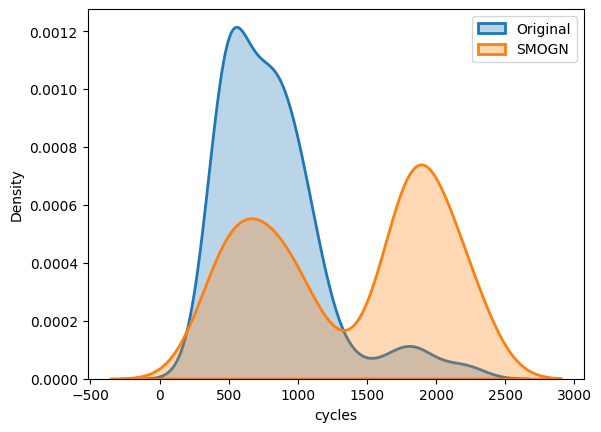

In [20]:
sns.kdeplot(init_df['cycles'], label="Original", fill=True, alpha=0.3, linewidth=2)
sns.kdeplot(smogn_dataframe['cycles'], label="SMOGN", fill=True, alpha=0.3, linewidth=2)

plt.legend(loc='upper right')  # Move legend to upper right corner
plt.show()

In [ ]:
var_ar_smogn =  smogn_dataframe['var_DQ_100_10'].values
cmap1_smogn = plt.get_cmap('coolwarm')
cycles_ar_smogn = smogn_dataframe['cycles'].values

colors_2_c_smogn = [cmap1_smogn(1-(x - min(cycles_ar_smogn)) / (max(cycles_ar_smogn) - min(cycles_ar_smogn))) for x in cycles_ar_smogn]
plotly_colors_smogn = [f'rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, 1)' for color in colors_2_c_smogn]

fig_2c_smogn = go.Figure()
fig_2c_smogn.add_trace(go.Scatter(x=var_ar_smogn,
                          y=cycles_ar_smogn,

  mode='markers',marker=dict(size=22,color=plotly_colors_smogn,
            opacity=1, )))
fig_2c_smogn.update_layout( yaxis = dict(type='log',title = 'Cycle life',range=[2,4]),
                  xaxis=dict( range = [-8,-1], # define the range of x-axis range=[-0.002,0.]
                            title='Var ΔQ100_10(V)',  # optional title
                             type='log'
                             ))
fig_2c_smogn.show()
# CALCULATION OF PEARSON CORRELATION FOR LOG SCALE
cycle_ar_log_scale_smogn = np.array([np.log10(c_l) for c_l in cycles_ar_smogn])
var_ar_log_scale_smogn = np.array([np.log10(va) for va in var_ar_smogn])
pear_2C_smogn = np.corrcoef(var_ar_log_scale_smogn,cycle_ar_log_scale_smogn)[0,1]
print(f" The pearson correlation is {pear_2C_smogn}")

 The pearson correlation is -0.9268685189980086


# train an elastic net regression model

**Let the train begins!!!**

In [ ]:
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
init_model_df = init_df.copy()
# init_model_df = convert_values_tol_log_scale(df_data = init_model_df.copy())
X_init_model_copy = init_model_df.drop(columns=['cycles','average_charge_2_WI','discharge_cycle_WI','cycle_bin', 'cycle_bin_label'])
Y_init_copy = init_model_df['cycles']
x_train_init,x_test,ytrain_init,y_test = train_test_split(X_init_model_copy,Y_init_copy,
                                                          test_size=0.3,random_state=0 )
# we need to convert that values to log_scale  both for x_Train and y_train

In [ ]:
train_df = pd.concat([x_train_init,ytrain_init],axis=1) # this add to smogn
test_df = pd.concat([x_test,y_test],axis=1)
test_df = convert_values_tol_log_scale(df_data = test_df.copy()) # Log scale only for test set!!

In [ ]:
x_test_f,y_test_f = test_df.drop(columns=['cycles']),test_df['cycles']
train_df.reset_index(inplace=True,drop=True)

In [ ]:
smogn_dataframe_model = smogn.smoter(data =train_df.copy(), y='cycles',k=9,samp_method='extreme',rel_thres=0.9,rel_method='auto',rel_xtrm_type='high',rel_coef=2.25)

synth_matrix: 100%|##########| 6/6 [00:00<00:00, 26.41it/s]


In [ ]:
var_ar_smogn_train =  smogn_dataframe_model ['var_DQ_100_10'].values
cmap1_smogn = plt.get_cmap('coolwarm')
cycles_ar_smogn_train = smogn_dataframe_model ['cycles'].values

colors_2_c_smogn = [cmap1_smogn(1-(x - min(cycles_ar_smogn_train)) / (max(cycles_ar_smogn_train) - min(cycles_ar_smogn_train))) for x in cycles_ar_smogn_train]
plotly_colors_smogn = [f'rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, 1)' for color in colors_2_c_smogn]

fig_2c_smogn_train = go.Figure()
fig_2c_smogn_train.add_trace(go.Scatter(x=var_ar_smogn_train,
                          y=cycles_ar_smogn_train,

  mode='markers',marker=dict(size=22,color=plotly_colors_smogn,
            opacity=1, )))
fig_2c_smogn_train.update_layout( yaxis = dict(type='log',title = 'Cycle life',range=[2,4]),
                  xaxis=dict( range = [-8,-1], # define the range of x-axis range=[-0.002,0.]
                            title='Var ΔQ100_10(V)',  # optional title
                             type='log'
                             ))
fig_2c_smogn_train.show()
# CALCULATION OF PEARSON CORRELATION FOR LOG SCALE
cycle_ar_log_scale_smogn = np.array([np.log10(c_l) for c_l in cycles_ar_smogn_train])
var_ar_log_scale_smogn = np.array([np.log10(va) for va in var_ar_smogn_train])
pear_2C_smogn = np.corrcoef(var_ar_log_scale_smogn,cycle_ar_log_scale_smogn)[0,1]
print(f" The pearson correlation is {pear_2C_smogn}")

 The pearson correlation is -0.9278763522226069


In [ ]:
smogn_dataframe_model = convert_values_tol_log_scale(df_data=smogn_dataframe_model.copy())
xtrain_final, ytrain_final = smogn_dataframe_model.drop(columns=['cycles']),smogn_dataframe_model['cycles']
finite_mask = np.isfinite(xtrain_final['skew_100_10'])
# Calculate the mean of finite values only
finite_mean = xtrain_final.loc[finite_mask, 'skew_100_10'].mean()
# Replace inf and -inf with the finite mean
xtrain_final.loc[~finite_mask, 'skew_100_10'] = finite_mean

<ipython-input-4-8e0b558d523b>:7: RuntimeWarning:

divide by zero encountered in log10



In [ ]:
# Define parameter grids
parameter_elastic_net = {
    'alpha': [1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 0.001, 0.01, 0.1, 0.4, 0.5, 0.6, 0.9, 1.0],
    'l1_ratio': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.78, 0.8, 0.82, 0.85, 0.86, 0.9]
}

# GridSearchCV for both models
grid_search_elastic = GridSearchCV(
    estimator=ElasticNet(max_iter=5000),
    param_grid=parameter_elastic_net,
    scoring='neg_mean_absolute_error',
    cv=5, n_jobs=-1, verbose=0)


grid_search_elastic.fit(xtrain_final, ytrain_final)


# Best estimators
best_model_ELA = grid_search_elastic.best_estimator_

# Predict on test set
preds_test_ELA = best_model_ELA.predict(x_test_f)

# Convert back from log scale
actual_test, pred_test_ela = convert_from_log_to_normal(y_test_f, preds_test_ELA)

# Compute metrics
mae_ela = mean_absolute_error(actual_test, pred_test_ela)
rmse_ela =  np.sqrt(mean_squared_error(actual_test, pred_test_ela))


# Create individual DataFrames
elastic_df = pd.DataFrame({
    'Model': ['ElasticNet'],
    'MAE': [mae_ela],
    'RMSE': [rmse_ela],
    'Best Parameters': [grid_search_elastic.best_params_]
})


# Display results
print("📊 ElasticNet Results:")
print(elastic_df, "\n")

📊 ElasticNet Results:
        Model         MAE        RMSE                    Best Parameters
0  ElasticNet  104.432432  143.484437  {'alpha': 1e-05, 'l1_ratio': 0.9} 



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e-01, tolerance: 9.755e-04



In [ ]:
parameters_random_forests = {
    'n_estimators': [1, 3, 5, 10, 30, 50, 100, 1000],
    'criterion': ['absolute_error'],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5]
}
grid_search_forest = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=parameters_random_forests,
    scoring='neg_mean_absolute_error',
    cv=5, n_jobs=-1, verbose=0
)

grid_search_forest.fit(xtrain_final, ytrain_final)
best_model_FOREST = grid_search_forest.best_estimator_
preds_test_FOREST = best_model_FOREST.predict(x_test_f)

actual_test, pred_test_forest = convert_from_log_to_normal(y_test_f, preds_test_FOREST)


mae_forest = mean_absolute_error(actual_test, pred_test_forest)
rmse_forest = np.sqrt( mean_squared_error(actual_test, pred_test_forest))


forest_df = pd.DataFrame({
    'Model': ['RandomForest'],
    'MAE': [mae_forest],
    'RMSE': [rmse_forest],
    'Best Parameters': [grid_search_forest.best_params_]
})
print("🌲 RandomForest Results:")
print(forest_df)

🌲 RandomForest Results:
          Model        MAE        RMSE  \
0  RandomForest  89.054054  131.726477   

                                     Best Parameters  
0  {'criterion': 'absolute_error', 'max_depth': N...  
